In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
from __future__ import annotations
import jax
import jax.numpy as jnp
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from jax import vmap

from typing import Optional, List, Dict, Any, Union, Set, Tuple
from dataclasses import dataclass, field

In [3]:
def swc_to_morph_tree(fname: str, num_lines: Optional[int] = None) -> MorphTree:
    i_id_xyzr_p = np.loadtxt(fname)[:num_lines]
    
    node_attrs, edge_attrs = {}, {}
    for i, id, x, y, z, r, p in i_id_xyzr_p.tolist(): # tolist: np.float64 -> float
        node_attrs[int(i)] = {"id": int(id), "x": x, "y": y, "z": z, "r": r}
        if p != -1:
            edge_attrs[int(p), int(i)] = {}
    
    return MorphTree(node_attrs, edge_attrs)

@jax.tree_util.register_dataclass
@dataclass
class MorphTree:
    node_attrs: Dict[int, Dict[str, Any]]
    edge_attrs: Dict[Tuple[int, int], Dict[str, Any]]
    global_attrs: Dict[str, Any] = field(default_factory=dict)

    @property
    def nodes(self) -> jnp.ndarray:
        return jnp.array(list(self.node_attrs.keys())).astype(int)

    @property
    def edges(self) -> jnp.ndarray:
        return jnp.array(list(self.edge_attrs.keys())).astype(int)

    def __repr__(self) -> str:
        n_nodes = len(self.node_attrs)
        n_edges = len(self.edge_attrs)

        node_keys = list(next(iter(self.node_attrs.values())).keys())
        edge_keys = list(next(iter(self.edge_attrs.values())).keys())

        node_attrs = node_keys if len(self.node_attrs) > 0 else []
        edge_attrs = edge_keys if len(self.edge_attrs) > 0 else []
        return f"MorphTree(nodes={n_nodes}*{node_attrs}, edges={n_edges}*{edge_attrs})"
    
    def node(self, i: int) -> Dict[str, Any]:
        return self.node_attrs[i]
    
    def edge(self, i: int, j: int) -> Dict[str, Any]:
        return self.edge_attrs[i, j]
    
    def to_nx(self) -> nx.DiGraph:
        G = nx.DiGraph()
        G.add_nodes_from(self.node_attrs.items())
        G.add_edges_from((i, j, d) for (i, j), d in self.edge_attrs.items())
        G.graph.update(self.global_attrs)
        return G
    
    @staticmethod
    def from_nx(G: nx.DiGraph) -> MorphTree:
        node_attrs = {n: G.nodes[n] for n in G.nodes}
        edge_attrs = {(i, j): G.edges[i, j] for i, j in G.edges}
        return MorphTree(node_attrs, edge_attrs, G.graph)
    
    def to_pandas(self, return_global_attrs: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
        node_df = pd.DataFrame(self.node_attrs.values(), index=self.node_attrs.keys())
        edge_df = pd.DataFrame(self.edge_attrs.values(), index=self.edge_attrs.keys())
        edge_index = pd.MultiIndex.from_arrays(np.array(self.edges).T)
        edge_df = edge_df.set_index(edge_index)

        if return_global_attrs:
            return node_df, edge_df, pd.Series(self.global_attrs)
        return node_df, edge_df
    
    @staticmethod
    def from_pandas(node_df: pd.DataFrame, edge_df: pd.DataFrame, global_attrs: pd.Series = pd.Series()) -> MorphTree:
        node_attrs = node_df.to_dict(orient="index")
        edge_attrs = edge_df.to_dict(orient="index")
        return MorphTree(node_attrs, edge_attrs, global_attrs.to_dict())
    
    def plot(self, dims=(0,1),**kwargs: Any) -> None:
        G = self.to_nx()
        pos = {}
        dims2axes = {0: "x", 1: "y", 2: "z"}
        for n, attr in G.nodes(data=True):
            if "x" in attr:  # assume y is also present
                pos[n] = (attr[dims2axes[dims[0]]], attr[dims2axes[dims[1]]])
        nx.draw(G, pos, with_labels=True, **kwargs)
        plt.show()

    def reindex_nodes(self, mapping: dict) -> MorphTree:
        new_node_attrs = {mapping[i]: attrs for i, attrs in self.node_attrs.items()}
        
        new_edge_attrs = {}
        for (i, j), attrs in self.edge_attrs.items():
            new_edge_attrs[(mapping[i], mapping[j])] = attrs
            
        return MorphTree(new_node_attrs, new_edge_attrs)
    
    def reorder_tree(self, new_order: np.ndarray) -> MorphTree:
        # TODO: check this does what I think it does, i.e. change the edge orientation
        # in order of appearance of the nodes in self.nodes.
        edges = np.array(self.edges)
        idx_i = np.where(edges[:,0] == new_order[:, None])[0]
        idx_j = np.where(edges[:,1] == new_order[:, None])[0]
        is_descending = ~(idx_i < idx_j)
        for (i,j) in edges[is_descending]:
            print(i,j)
            self.edge_attrs[j, i] = self.edge_attrs.pop((i, j))
        return self
    
    def subgraph(self, nodes: List[int]) -> MorphTree:
        node_attrs_subset = {i: self.node_attrs[i] for i in nodes}
        edge_attrs_subset = {(i,j): attrs for (i,j), attrs in self.edge_attrs.items() if i in nodes and j in nodes}
        return MorphTree(node_attrs_subset, edge_attrs_subset, self.global_attrs)

def list_branches(tree: MorphTree, return_branchpoints: bool = False) -> Union[List[List[int]], Tuple[List[List[int]], Set[int], List[Tuple[int, int]]]]:
    G = tree.to_nx().to_undirected()
    branches = []
    branchpoints = set()
    visited = set()

    def is_branchpoint_or_tip(n: int) -> bool:
        is_leaf = G.degree(n) <= 1
        is_branching = G.degree(n) > 2
        if G.degree(n) == 2:
            i,j = G.neighbors(n)
             # trace dir matters here! For segment with node IDs: [1, 1, 2, 2]
             # -> [[1,1], [1,2,2]] 
             # <- [[2,2], [2,1,1]] 
            return not same_id(n, j)
        
        return is_leaf or is_branching

    def in_visited(n1: int, n2: int) -> bool:
        return (n1, n2) in visited or (n2, n1) in visited

    def same_id(n1: int, n2: int) -> bool:
        return G.nodes[n1]["id"] == G.nodes[n2]["id"] if "id" in G.nodes[n1] else True

    def is_soma(n: int) -> bool:
        return G.nodes[n]["id"] == 1
    
    def soma_nodes() -> bool:
        return [i for i, n in G.nodes.items() if n["id"] == 1]

    def walk_path(start: int, succ: int) -> List[int]:
        path = [start, succ]
        visited.add((start, succ))
 
        while G.degree(succ) == 2:
            next_node = next(n for n in G.neighbors(succ) if n != path[-2])

            if in_visited(succ, next_node) or is_branchpoint_or_tip(succ):
                break
            
            path.append(next_node)
            visited.add((succ, next_node))
            succ = next_node

        return path

    leaf = next(n for n in G.nodes if G.degree(n) == 1)
    single_soma = len(soma_nodes()) == 1
    for node in nx.dfs_tree(G, leaf):
        if single_soma and is_soma(node):
            branches.append([node])

        elif is_branchpoint_or_tip(node):
            branchpoints.add(node)
            for succ in G.neighbors(node):
                if not in_visited(node, succ):
                    branches.append(walk_path(node, succ))
    
    if return_branchpoints:
        branchpoint_edges = sum([list(G.edges(n)) for n in branchpoints], [])
        return branches, branchpoints, branchpoint_edges
    return branches

def _find_swc_tracing_interruptions(tree: MorphTree) -> np.ndarray:
    G = tree.to_nx()
    degree_is_2 = lambda n: G.out_degree(n) + G.in_degree(n) == 2

    interrupt_edges = []
    for n in G.nodes:
        if len(parents := list(G.predecessors(n))) > 0:
            p = parents[0] 
            if p != n-1 and degree_is_2(n) and degree_is_2(p):
                interrupt_edges.append((p,n))
    return interrupt_edges

def _split_interrupted_branches(branches, split_edges) -> MorphTree:
    for (p,n) in split_edges:
        for i, branch in enumerate(branches):
            if n in branch:
                split_idx = branch.index(n)
                branches[i:i+1] = [branch[:split_idx], branch[split_idx:]]
                break
    return branches

def compartmentalize(tree: MorphTree, num_comps: int = 1) -> MorphTree:
    branches = list_branches(tree)
    nodes_df = tree.to_pandas()[0].astype(float)

    # create new set of indices which arent already used as node indices to label comps
    existing_inds = set(nodes_df.index)
    num_new_inds = len(branches)*num_comps
    proposed_inds = set(range(num_new_inds + len(existing_inds)))
    proposed_comp_inds = list(proposed_inds - existing_inds) # avoid overlap w. node indices
    
    v_interp = vmap(jnp.interp, in_axes=(None, None, 1), out_axes=1)
    
    # identify tip nodes (degree == 1)
    nodes_in_edges, node_counts_in_edges = np.unique(tree.edges, return_counts=True)
    tip_node_inds = nodes_in_edges[node_counts_in_edges == 1]

    # collect comps and comp_edges
    branch_nodes, branch_edges = [], []
    for i, branch in enumerate(branches):
        node_attrs = nodes_df.loc[branch]
        xyz_i = node_attrs[["x", "y", "z"]]
        edge_lens = ((xyz_i.diff(axis=0).fillna(0)**2).sum(axis=1)**.5)
        # TODO: handle nans
        node_attrs["l"] = edge_lens.cumsum() # path length
        
        # For single-point somatata, we set l = 2*r this ensures
        # A_cylinder = 2*pi*r*l = 4*pi*r^2 = A_sphere.
        if len(branch) == 1:
            node_attrs = node_attrs.loc[branch*2] # duplicate soma node
            radius = node_attrs["r"].iloc[0]
            node_attrs["l"] = np.array([0, 2*radius])

        branch_id = node_attrs["id"].iloc[-1] # TODO: handle multi ids within branch!
        branch_len = max(node_attrs["l"])
        comp_len = branch_len / num_comps
        comp_locs = list(np.linspace(comp_len/2, branch_len - comp_len/2, num_comps))
        
        # Create node indices and attributes
        # branch_inds, branchpoint, comp_id, comp_len
        branch_tips = branch[0], branch[-1]
        branch_tip_attrs = [[i, True, node_attrs["id"].iloc[0], 0],
                            [i, True, node_attrs["id"].iloc[-1], 0]]
        comp_attrs = [i, False, branch_id, comp_len]*num_comps

        comp_inds = proposed_comp_inds[i*num_comps:(i+1)*num_comps]
        comp_inds = np.array([branch_tips[0], *comp_inds, branch_tips[1]])
        comp_attrs = [branch_tip_attrs[0]] + [comp_attrs] + [branch_tip_attrs[1]]
        comp_attrs = np.hstack([comp_inds[:, None], comp_attrs])
        
        # Interpolate xyzr coordinates and combine with attributes
        x = jnp.array([0] + comp_locs + [branch_len]) # 0, branch_len = branchpoints
        xp = jnp.array(node_attrs["l"].values)
        fp = jnp.array(node_attrs[["x", "y", "z", "r"]].values)
        #TODO: interpolate r differently!
        comp_attrs = np.hstack([comp_attrs, np.array(v_interp(x, xp, fp))])
        
        # remove tip nodes
        comp_attrs = comp_attrs[1:] if branch_tips[0] in tip_node_inds else comp_attrs
        comp_attrs = comp_attrs[:-1] if branch_tips[1] in tip_node_inds else comp_attrs

        # Store edges and nodes
        branch_edges.append(list(zip(comp_attrs[:-1, 0], comp_attrs[1:, 0])))
        branch_nodes.append(comp_attrs)

    # TODO: add missing attrs, cell_index, axial_resistvity, membrane_capacitance, voltage
    branch_nodes = jnp.concatenate(branch_nodes)
    comp_attrs_keys = ["idx", "branch", "branchpoint", "id", "l", "x", "y", "z", "r"]
    comp_df = pd.DataFrame(branch_nodes, columns=comp_attrs_keys)
    int_cols = ["idx", "branch", "id"]
    bool_cols = ["branchpoint"]
    comp_df[int_cols] = comp_df[int_cols].astype(int)
    comp_df[bool_cols] = comp_df[bool_cols].astype(bool)
    
    # drop duplicated branch nodes
    comp_df = comp_df.drop_duplicates(subset=["idx"])
    comp_df = comp_df.set_index("idx")

    comp_attrs = comp_df.to_dict(orient="index")
    comp_edges = sum(branch_edges, [])
    comp_edge_attrs = {(i,j): {"comp_edge": True, "synapse": False} for i,j in comp_edges}

    comp_tree = MorphTree(comp_attrs, comp_edge_attrs)
    comp_tree = comp_tree.reindex_nodes(dict(zip(comp_df.index, range(len(comp_df)))))
    return comp_tree

def _add_meta_data(tree: MorphTree) -> MorphTree:
    global_attrs = {"channels": {}, "synapses": {}, "xyzr": None} # TODO: add xyzr

    group_ids = {0: "undefined", 1: "soma", 2: "axon", 3: "basal", 4: "apical"}
    fill_w = lambda x: np.full(len(tree.nodes), x)

    nodes_df, edge_df = tree.to_pandas()
    nodes_df["cell"] = fill_w(0)
    nodes_df["comp"] = np.arange(len(nodes_df))
    nodes_df["id"] = nodes_df["id"].apply(lambda x: [group_ids[x]])
    nodes_df = nodes_df.rename(columns={"r": "radius", "l": "length", "id": "groups"})
    nodes_df["capacitance"] = fill_w(1.0)
    nodes_df["v"] = fill_w(-70.0)
    nodes_df["axial_resistivity"] = fill_w(1000.0)

    return MorphTree.from_pandas(nodes_df, edge_df, pd.Series(global_attrs))

def _add_missing_attrs(tree: MorphTree) -> MorphTree:
    nan = float("nan")
    defaults = {"id": 0, "x": nan, "y": nan, "z": nan, "r": 1}

    for i in tree.node_attrs:
        for key in set(defaults.keys()).difference(tree.node_attrs.keys()):
            tree.node_attrs[i][key] = defaults[key]
    return tree

# def set_solve_order(tree: MorphTree, solve_order: List[int]) -> MorphTree:
#     # TODO: do we want to rm branchpoints and comp_edges?
#     return

/tmp/ipykernel_721647/3617806162.py:32: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  z = z0 + length * np.cos(ph) * ~(xy_only)


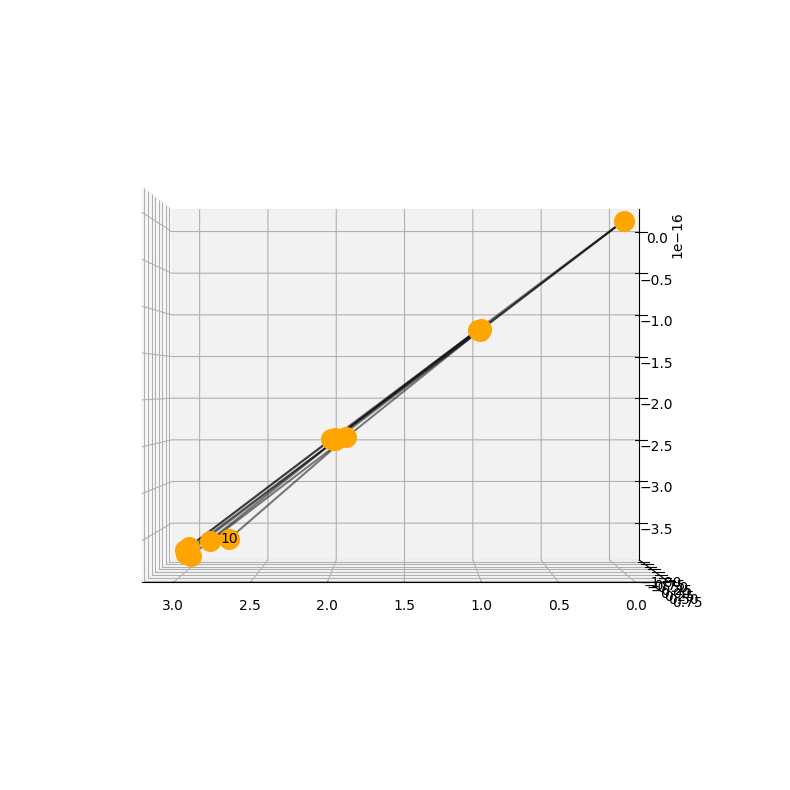

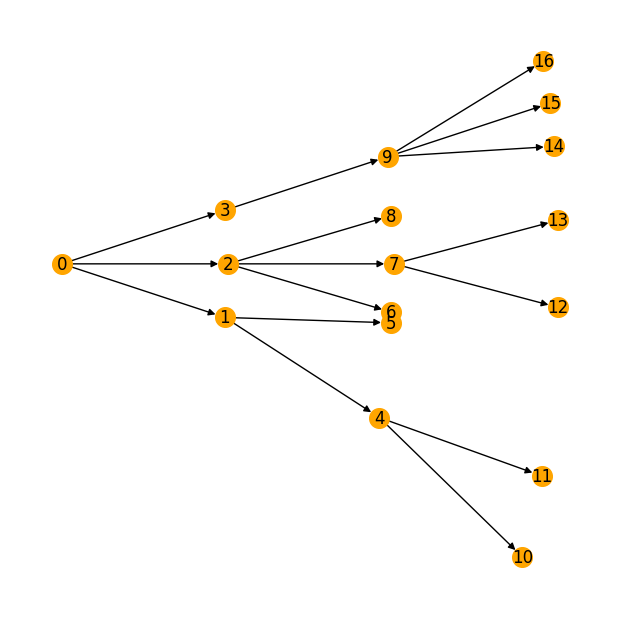

In [ ]:
def create_xyz_tree(
    G, 
    length=1.0, 
    spread=np.pi/8,
    spread_decay=0.9, 
    xy_only=False,
    twist=0.0
):
    root = next(n for n, d in G.in_degree() if d == 0)
    pos = {root: (0.0, 0.0, 0.0)}

    def recurse(node, depth=1, theta=0.0, phi=np.pi/2):
        children = [n for n in G.successors(node) if n not in pos]
        if not children: return
        n = len(children)
        curr_spread = spread * (spread_decay ** (depth - 1))
        x0, y0, z0 = pos[node]
        phi = np.pi/2 if xy_only else phi
        base_theta = theta + depth * twist
        if n == 1:
            thetas, phis = [base_theta], [phi]
        else:
            if xy_only:
                thetas = np.linspace(base_theta - curr_spread/2, base_theta + curr_spread/2, n)
                phis = [phi] * n
            else:
                thetas = np.linspace(base_theta, base_theta + 2 * np.pi, n, endpoint=False)
                phis = [phi - curr_spread] * n
        for th, ph, child in zip(thetas, phis, children):
            x = x0 + length * np.sin(ph) * np.cos(th)
            y = y0 + length * np.sin(ph) * np.sin(th)
            z = z0 + length * np.cos(ph) * (not xy_only)
            pos[child] = (x, y, z)
            recurse(child, depth + 1, th, ph)

    recurse(root, theta=0.0, phi=np.pi/2)
    for n, (x, y, z) in pos.items():
        G.nodes[n].update({'x': float(x), 'y': float(y), 'z': float(z)})
    return G

# Create a simple tree
G = nx.DiGraph()
edges = [
    (0, 1), (0, 2), (0, 3),        # root 0 branches to 1, 2, 3
    (1, 4), (1, 5),                # node 1 branches to 4, 5
    (2, 6), (2, 7), (2, 8),        # node 2 branches to 6, 7, 8
    (3, 9),                        # node 3 branches to 9
    (4, 10), (4, 11),              # node 4 branches to 10, 11
    (7, 12), (7, 13),              # node 7 branches to 12, 13
    (9, 14), (9, 15), (9, 16)      # node 9 branches to 14, 15, 16
]
G.add_edges_from(edges)

G = create_xyz_tree(G, xy_only=True)

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Get 3D positions
pos_3d = {n: (G.nodes[n]['x'], G.nodes[n]['y'], G.nodes[n]['z']) for n in G.nodes}

# Plot nodes
for node, (x, y, z) in pos_3d.items():
    ax.scatter(x, y, z, c='orange', s=200)
    ax.text(x, y, z, str(node), ha='center', va='center')

# Plot edges
for (u, v) in G.edges():
    x1, y1, z1 = pos_3d[u]
    x2, y2, z2 = pos_3d[v]
    ax.plot([x1, x2], [y1, y2], [z1, z2], 'k-', alpha=0.5)

ax.view_init(elev=0, azim=90)  # Rotate the view: elevation=20 degrees, azimuth=45 degrees
plt.show()

# Also show the 2D projection for reference
plt.figure(figsize=(6, 6))
pos_2d = {n: (G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
nx.draw(G, pos_2d, with_labels=True, node_color='orange', node_size=200, arrows=True)
plt.show()

In [86]:
class DummyChannel:
    def __init__(self, name = None):
        self.name = self.__class__.__name__ if name is None else name
        self.params = {f"gbar_{self.name}": 1.0, f"e_{self.name}": 0.0, f"nn_weights_{self.name}": jnp.ones((10, 10))}
        self.states = {f"m_{self.name}": 0.5, f"h_{self.name}": 0.5}

def tree_insert(tree, inds, channel):
    # TODO: Should Module and MorphTree be separate or the same thing?
    tree.global_attrs["channels"][channel.name] = channel
    for i in inds:
        tree.node_attrs[i].update(channel.params)
        tree.node_attrs[i].update(channel.states)

def tree_set(tree, key, value):
    nodes_df, edge_df = tree.to_pandas()
    # if ... if, since param could be in both nodes and edges
    if key in nodes_df.columns:
        valid = ~nodes_df[key].isna() & ~nodes_df.branchpoint
        nodes_df.loc[valid, key] = value
    if key in edge_df.columns:
        valid = ~edge_df[key].isna() & edge_df.synapse
        edge_df.loc[valid, key] = value
    return MorphTree.from_pandas(nodes_df, edge_df, pd.Series(tree.global_attrs))

    # # not vectorized, but allows to modify in place
    # nodes_df, edge_df = tree.to_pandas()
    # if key in nodes_df.columns:
    #     for i in tree.node_attrs:
    #         if key in tree.node_attrs[i]:
    #             tree.node_attrs[i][key] = value
    # if key in edge_df.columns:
    #     for i, j in tree.edge_attrs:
    #         if key in tree.edge_attrs[(i,j)]:
    #             tree.edge_attrs[(i,j)][key] = value


#TODO: split/merge similar to equinox
def merge_trees(trees: List[MorphTree]) -> MorphTree:
    tree = trees[0]
    for t in trees[1:]:
        tree.node_attrs.update(t.node_attrs)
        tree.edge_attrs.update(t.edge_attrs)
    return tree

# def split_tree(tree: MorphTree, nodes: List[int]) -> List[MorphTree]:
#     pass

def tree_to_pytree(tree):
    nodes_df, edge_df = tree.to_pandas()
    jax_nodes, jax_edges = {}, {}
    
    node_data = nodes_df.loc[~nodes_df.branchpoint]
    node_data = node_data.drop(columns=["branch", "branchpoint", "groups"])
    for key in node_data.columns:
        values = jnp.array(node_data.loc[~node_data[key].isna(), key].to_list())
        jax_nodes[key] = values

    edge_data = edge_df.loc[edge_df.synapse]
    edge_data = edge_data.drop(columns=["comp_edge", "synapse"])
    for key in edge_data.columns:
        values = jnp.array(edge_data.loc[~edge_data[key].isna(), key].to_list())
        jax_edges[key] = values
    return jax_nodes, jax_edges

def tree_view(tree: MorphTree, nodes: List[int]) -> MorphTree:
    return tree.subgraph(nodes)

class DummySynapse:
    def __init__(self, name = None):
        self.name = self.__class__.__name__ if name is None else name
        self.params = {f"gbar_{self.name}": 1.0, f"e_{self.name}": 0.0, f"nn_weights_{self.name}": jnp.ones((10, 10))}
        self.states = {f"m_{self.name}": 0.5, f"h_{self.name}": 0.5}

def tree_connect(tree, pre, post, synapse):
    # TODO: map / vectorize this
    tree.global_attrs["synapses"][synapse.name] = synapse
    for i, j in zip(pre, post):
        if (i,j) not in tree.edge_attrs:
            tree.edge_attrs[(i,j)] = {"comp_edge": False}
        tree.edge_attrs[i, j]["synapse"] = True
        tree.edge_attrs[i, j].update(synapse.params)
        tree.edge_attrs[i, j].update(synapse.states)


# There can only be one edge per pair of nodes. (or use MultiDiGraph).
# This means all synapses need to live in the same edge (i,j)
# -> treat synapses more like channels, i.e. multiple channels per row in nodes -> multiple synapses per edge.
# downside cannot connect i and j with the same synapse twice, but can do if one synapse is named differently.
# think about how to handle if i,j is a comp_edge and also connects via synapses

# TODO: node and edge attrs as list or dict?
# - pro: one can change node / edge idx without changing touching attrs, since pos of node_idx -> pos node_attr
# - con: hard to index into node / edge attrs

# TODO: get rid of xyzr in most usecases and use the comp / node xyzrs!? -> simplifies all plotting to networkx!
    

In [239]:
jax.tree.flatten(morph_comps)

([1000.0,
  0,
  False,
  1.0,
  0,
  0,
  0.0,
  0.0,
  1.0,
  1.0,
  'apical',
  0.5,
  0.5,
  99.99,
  0.5,
  0.5,
  Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float64),
  Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]

In [356]:
from jaxley.io.graph import build_compartment_graph, to_swc_graph, _trace_branches, _remove_branch_points

testcases = [ 
"morph_3_types_single_point_soma.swc",
"morph_3_types.swc",
"morph_interrupted_soma.swc",
"morph_soma_both_ends.swc",
"morph_somatic_branchpoint.swc",
"morph_non_somatic_branchpoint.swc", # no soma!
"morph_ca1_n120_single_point_soma.swc",
"morph_ca1_n120.swc",
"morph_l5pc_with_axon.swc",
"morph_allen_485574832.swc",
]

jx_graph = to_swc_graph("../jaxley/tests/swc_files/"+testcases[-3])
# jx_comps = build_compartment_graph(jx_graph.copy(), ncomp=1)

morph_tree = swc_to_morph_tree("../jaxley/tests/swc_files/"+testcases[-3])
morph_comps = compartmentalize(morph_tree, num_comps=1)
morph_comps = _add_meta_data(morph_comps)

In [222]:
tree_insert(morph_comps, [0, 2], DummyChannel("test1"))
tree_insert(morph_comps, [0, 2], DummyChannel("test2"))

tree_connect(morph_comps, [0, 1], [3, 2], DummySynapse("test1"))
tree_connect(morph_comps, [0, 1], [1, 2], DummySynapse("test2"))

tree_set(morph_comps, "gbar_test1", 123)
tree_set(morph_comps, "gbar_test2", 123)

subtree = tree_view(morph_comps, list(range(0,2)))
subtree = tree_set(subtree, "length", 99.99) # <-- setting on views works
morph_comps = merge_trees([morph_comps, subtree])

In [244]:
morph_comps.to_pandas()[0]["nn_weights_test1"]

0      [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
1                                                    NaN
2      [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
3                                                    NaN
4                                                    NaN
                             ...                        
228                                                  NaN
229                                                  NaN
230                                                  NaN
231                                                  NaN
232                                                  NaN
Name: nn_weights_test1, Length: 233, dtype: object

In [260]:
jax_nodes, jax_edges = tree_to_pytree(morph_comps)

In [1582]:
from jaxley.io.graph import build_compartment_graph, to_swc_graph, _trace_branches

testcases = [ 
"morph_3_types_single_point_soma.swc",
"morph_3_types.swc",
"morph_interrupted_soma.swc",
"morph_soma_both_ends.swc",
"morph_somatic_branchpoint.swc",
"morph_non_somatic_branchpoint.swc", # no soma!
"morph_ca1_n120_single_point_soma.swc",
"morph_ca1_n120.swc",
"morph_l5pc_with_axon.swc",
"morph_allen_485574832.swc",
]

for i, testcase in enumerate(testcases):
    jx_graph = to_swc_graph("../jaxley/tests/swc_files/"+testcase)

    morph_branches = list_branches(MorphTree.from_nx(jx_graph.copy()))
    morph_branch_nodes = [np.sort(b) for b in morph_branches]

    # do jx_trace after morph_traces, since jax_trace modifies the graph
    jx_branches = _trace_branches(jx_graph.copy())[1]
    jx_branch_nodes = [np.sort(np.unique(b[:, :-1])) for b in jx_branches]
    if i in [0,6,9]: # single soma
        jx_branch_nodes = [b-1 for b in jx_branch_nodes]

    morph_eq_jx = []

    for i, b in enumerate(jx_branch_nodes):
        for j, mb in enumerate(morph_branch_nodes):
            if len(b) == len(mb):
                if np.allclose(b, mb):
                    morph_eq_jx.append((i,j))
                    break
    if len(morph_eq_jx) > 0:
        diff_morph_branches = [b for i, b in enumerate(morph_branch_nodes) if i not in np.array(morph_eq_jx)[:,1]]
        diff_jx_branches = [b for j, b in enumerate(jx_branch_nodes) if j not in np.array(morph_eq_jx)[:,0]]
    else:
        print("No branches are equal")
        diff_morph_branches = morph_branch_nodes
        diff_jx_branches = jx_branch_nodes
    
    # single soma handled differently and will lead to 1 diff branch
    print(f"testcase {testcase}: {len(diff_morph_branches)}, {len(diff_jx_branches)}")

testcase morph_3_types_single_point_soma.swc: 1, 1
testcase morph_3_types.swc: 0, 0
testcase morph_interrupted_soma.swc: 0, 0
testcase morph_soma_both_ends.swc: 0, 0
testcase morph_somatic_branchpoint.swc: 0, 0
testcase morph_non_somatic_branchpoint.swc: 0, 0
testcase morph_ca1_n120_single_point_soma.swc: 1, 1
testcase morph_ca1_n120.swc: 0, 0
testcase morph_l5pc_with_axon.swc: 0, 0
testcase morph_allen_485574832.swc: 1, 1


In [867]:
# from jaxley.io.graph import build_compartment_graph, to_swc_graph, _trace_branches

# testcases = [ 
# "morph_3_types_single_point_soma.swc",
# "morph_3_types.swc",
# "morph_interrupted_soma.swc",
# "morph_soma_both_ends.swc",
# "morph_somatic_branchpoint.swc",
# "morph_non_somatic_branchpoint.swc", # no soma!
# "morph_ca1_n120_single_point_soma.swc",
# "morph_ca1_n120.swc",
# "morph_l5pc_with_axon.swc",
# "morph_allen_485574832.swc",
# ]

# jx_graph = to_swc_graph("../jaxley/tests/swc_files/"+testcases[2])

# morph_branches = list_branches(MorphTree.from_nx(jx_graph.copy()))
# morph_branch_nodes = [np.sort(b) for b in morph_branches]

# # do jx_trace after morph_traces, since jax_trace modifies the graph
# jx_branches = _trace_branches(jx_graph.copy())[1]
# jx_branch_nodes = [np.sort(np.unique(b[:, :-1])) for b in jx_branches]
# # jx_branch_nodes = [b-1 for b in jx_branch_nodes]


# morph_eq_jx = []

# for i, b in enumerate(jx_branch_nodes):
#     for j, mb in enumerate(morph_branch_nodes):
#         if len(b) == len(mb):
#             if np.allclose(b, mb):
#                 morph_eq_jx.append((i,j))
#                 break
# if len(morph_eq_jx) > 0:
#     diff_morph_branches = [b for i, b in enumerate(morph_branch_nodes) if i not in np.array(morph_eq_jx)[:,1]]
#     diff_jx_branches = [b for j, b in enumerate(jx_branch_nodes) if j not in np.array(morph_eq_jx)[:,0]]
# else:
#     print("No branches are equal")
#     diff_morph_branches = morph_branch_nodes
#     diff_jx_branches = jx_branch_nodes

# jx_subgraph = jx_graph.subgraph(np.unique(np.hstack(diff_morph_branches)))

# # Get node positions and colors
# pos = {node: (jx_subgraph.nodes[node]['x'], jx_subgraph.nodes[node]['y']) for node in jx_subgraph.nodes()}

# # Create figure with 1x3 subplots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Plot 1: Node indices
# node_colors = [jx_subgraph.nodes[node]['id'] for node in jx_subgraph.nodes()]
# nx.draw(jx_subgraph, pos=pos, node_color=node_colors, cmap='viridis', with_labels=True, ax=axes[0])
# axes[0].set_title('Node Indices')

# # Plot 2: JX branches
# node_colors = np.zeros(len(jx_subgraph.nodes()))
# for i, branch in enumerate(diff_jx_branches):
#     node_colors[np.isin(list(jx_subgraph.nodes()), branch)] = i + 1
# nx.draw(jx_subgraph, pos=pos, node_color=node_colors, cmap='tab10', with_labels=True, ax=axes[1])
# axes[1].set_title('JX Branches')

# # Plot 3: Morph branches
# node_colors = np.zeros(len(jx_subgraph.nodes()))
# for i, branch in enumerate(diff_morph_branches):
#     node_colors[np.isin(list(jx_subgraph.nodes()), branch)] = i + 1
# nx.draw(jx_subgraph, pos=pos, node_color=node_colors, cmap='tab10', with_labels=True, ax=axes[2])
# axes[2].set_title('Morph Branches')

# plt.tight_layout()
# plt.show()